In [145]:
from typing import NamedTuple, Union, Protocol, Callable
from jaxtyping import Float, Array, Int
import jax.numpy as jnp
import jax
from jax import lax
from jraph import GraphsTuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# === Graph Class ===
class Graph(GraphsTuple):
    pass

# === Minimal Cochain Class ===
class Cochain(NamedTuple):
    k: int
    coeffs: Float[Array, "N"]
    graph: Graph

    def __add__(self, other: "Cochain") -> "Cochain":
        return Cochain(self.k, self.coeffs + other.coeffs, graph=self.graph)

    def __mul__(self, other: Union[float, "Cochain"]) -> "Cochain":
        if isinstance(other, Cochain):
            return Cochain(self.k, self.coeffs * other.coeffs, graph=self.graph)
        return Cochain(self.k, self.coeffs * other, graph=self.graph)

    def __rmul__(self, other: float) -> "Cochain":
        return self * other

    def __truediv__(self, other: Union[float, "Cochain"]) -> "Cochain":
        if isinstance(other, Cochain):
            return Cochain(self.k, self.coeffs / other.coeffs, graph=self.graph)
        return Cochain(self.k, self.coeffs / other, graph=self.graph)

# === Core Operators ===
def coboundary(c: Cochain) -> Cochain:
    graph = c.graph
    delta = c.coeffs[graph.receivers] - c.coeffs[graph.senders]
    return Cochain(k=1, coeffs=delta, graph=graph)

def coboundary_adjoint(c: Cochain) -> Cochain:
    graph = c.graph
    coeffs = jnp.zeros(graph.nodes.shape[0])
    coeffs = coeffs.at[graph.receivers].add(c.coeffs)
    coeffs = coeffs.at[graph.senders].add(-c.coeffs)
    return Cochain(k=0, coeffs=coeffs, graph=graph)

def outdegree(graph: Graph) -> Int[Array, "N"]:
    outdeg = jnp.zeros(graph.nodes.shape[0])
    return outdeg.at[graph.senders].add(1)

def lift(c: Cochain) -> Cochain:
    graph = c.graph
    return Cochain(k=1, coeffs=c.coeffs[graph.senders], graph=graph)

def mass_preserving_lift(p: Cochain) -> Cochain:
    graph = p.graph
    cdeg = outdegree(graph)
    lifted = p.coeffs[graph.receivers] / cdeg[graph.receivers]
    return Cochain(k=1, coeffs=lifted, graph=graph)

def flow_field(p: Cochain, nu: Cochain) -> Cochain:
    return mass_preserving_lift(p) * nu

def continuity_equation_euler_step(p: Cochain, nu: Cochain, dt: float) -> Cochain:
    div = coboundary_adjoint(flow_field(p, nu))
    return p + dt * div

def simulate_continuity_equation_trajectory(
    p0: Cochain,
    nu_fn: Callable[[float], Cochain],
    num_steps: int = 1000
) -> list[Cochain]:
    dt = 1.0 / num_steps

    def step_fn(p: Cochain, i: int):
        t = i * dt
        nu = nu_fn(t)
        p_next = continuity_equation_euler_step(p, nu, dt)
        return p_next, p_next

    _, ps = lax.scan(step_fn, p0, jnp.arange(num_steps))
    return [p0] + [Cochain(p0.k, ps.coeffs[i], graph=p0.graph) for i in range(num_steps)]

# === Biharmonic Distance ===
def graph_laplacian(graph: Graph) -> Float[Array, "N N"]:
    num_nodes = graph.nodes.shape[0]
    A = jnp.zeros((num_nodes, num_nodes))
    A = A.at[graph.senders, graph.receivers].set(1.0)
    A = A.at[graph.receivers, graph.senders].set(1.0)
    D = jnp.diag(jnp.sum(A, axis=1))
    return D - A

def incidence_matrix(graph: Graph) -> Array:
    num_nodes = graph.nodes.shape[0]
    num_edges = graph.senders.shape[0]
    B = jnp.zeros((num_nodes, num_edges))
    B = B.at[graph.receivers, jnp.arange(num_edges)].set(1.0)
    B = B.at[graph.senders, jnp.arange(num_edges)].add(-1.0)
    return B

def laplacian_eigenpairs(graph: Graph) -> tuple[Float[Array, "N"], Float[Array, "N N"]]:
    L = graph_laplacian(graph)
    eigvals, eigvecs = jnp.linalg.eigh(L)
    return eigvals, eigvecs

class Premetric(Protocol):
    def distance(self, x: int, y: int) -> float: ...
    def __call__(self, x: int, y: int) -> float: ...
    def conditional_distance(self, tau: int) -> Cochain: ...

class BiharmonicDistance(Premetric):
    def __init__(self, graph: Graph):
        self.graph = graph
        eigvals, eigvecs = laplacian_eigenpairs(self.graph)
        self.eigvals = eigvals[1:]
        self.eigvecs = eigvecs[:, 1:]

    def distance(self, x: int, y: int) -> float:
        diff_sq = (self.eigvecs[x] - self.eigvecs[y]) ** 2
        return jnp.sum(diff_sq / self.eigvals**2)

    def __call__(self, x: int, y: int) -> float:
        return self.distance(x, y)

    def conditional_distance(self, tau: int) -> Cochain:
        diff_sq = (self.eigvecs - self.eigvecs[tau]) ** 2
        return Cochain(k=0, coeffs=jnp.sum(diff_sq / self.eigvals**2, axis=1), graph=self.graph)

# === Conditional Flow Field ===
def linear_schedule(t: float) -> float:
    return 1 - t

def conditional_flow_field(tau: int, rho: Premetric, t: float) -> Cochain:
    graph = rho.graph
    rho_tau = rho.conditional_distance(tau)
    dlogkappa = jax.jacfwd(lambda x: jnp.log(linear_schedule(x)))(t)
    Lrho_tau = lift(rho_tau)
    delta_rho_tau = coboundary(rho_tau)
    coeffs = jnp.where(
        delta_rho_tau.coeffs <= 0,
        Lrho_tau.coeffs / delta_rho_tau.coeffs,
        jnp.zeros_like(Lrho_tau.coeffs)
    )
    return Cochain(k=1, coeffs=2 * dlogkappa * coeffs, graph=graph)

def uniform_distribution(graph: Graph) -> Cochain:
    num_nodes = graph.nodes.shape[0]
    return Cochain(k=0, coeffs=jnp.ones(num_nodes) / num_nodes, graph=graph)


# === Graph Builders ===
def build_circle_graph(n: int) -> Graph:
    senders = jnp.arange(n)
    receivers = (senders + 1) % n
    senders, receivers = jnp.concatenate((senders, receivers)), jnp.concatenate((receivers, senders))
    nodes = jnp.ones((n, 1))
    edges_feat = jnp.ones((len(senders), 1))
    return Graph(nodes=nodes, edges=edges_feat, senders=senders, receivers=receivers, n_node=jnp.array([n]), n_edge=jnp.array([len(senders)]), globals=None)

def build_karate_graph() -> Graph:
    import networkx as nx
    G = nx.karate_club_graph()
    num_nodes = G.number_of_nodes()
    edges = list(G.edges())
    senders = jnp.array([u for u, v in edges])
    receivers = jnp.array([v for u, v in edges])
    nodes = jnp.ones((num_nodes, 1))
    edges_feat = jnp.ones((len(edges), 1))
    return Graph(nodes=nodes, edges=edges_feat, senders=senders, receivers=receivers, n_node=jnp.array([num_nodes]), n_edge=jnp.array([len(edges)]), globals=None)

def build_example_graph() -> Graph:
    edges = jnp.array([[0, 1], [1, 2], [2, 0], [2, 3], [3, 4]])
    num_nodes = 5
    senders = edges[:, 0]
    receivers = edges[:, 1]
    nodes = jnp.ones((num_nodes, 1))
    edges_feat = jnp.ones((edges.shape[0], 1))
    return Graph(nodes=nodes, edges=edges_feat, senders=senders, receivers=receivers, n_node=jnp.array([num_nodes]), n_edge=jnp.array([edges.shape[0]]), globals=None)


# === Visualization ===
def plot_graph(graph: Graph):
    G = nx.Graph()
    for i in range(graph.nodes.shape[0]):
        G.add_node(i)
    for s, r in zip(graph.senders, graph.receivers):
        G.add_edge(int(s), int(r))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=600)
    plt.title("Example Graph")
    plt.show()

def plot_laplacian_eigenvectors(graph: Graph, num_vecs: int = 4):
    eigvals, eigvecs = laplacian_eigenpairs(graph)
    G = nx.Graph()
    for i in range(graph.nodes.shape[0]):
        G.add_node(i)
    for s, r in zip(graph.senders, graph.receivers):
        G.add_edge(int(s), int(r))
    pos = nx.spring_layout(G, seed=42)
    fig, axs = plt.subplots(1, num_vecs, figsize=(4 * num_vecs, 4))
    axs = axs if isinstance(axs, (list, np.ndarray)) else [axs]
    for i in range(num_vecs):
        eigvec = eigvecs[:, i]
        ax = axs[i]
        nodes = nx.draw_networkx_nodes(G, pos, node_color=eigvec, cmap="coolwarm", ax=ax)
        nx.draw_networkx_edges(G, pos, ax=ax)
        nx.draw_networkx_labels(G, pos, ax=ax)
        nodes.set_norm(plt.Normalize(vmin=-1, vmax=1))
        ax.set_title(f"Eigenvector {i}\nλ = {eigvals[i]:.2f}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def plot_biharmonic_distance(graph: Graph, source_node: int):
    biharmonic = BiharmonicDistance(graph)
    distances = jnp.array([biharmonic(source_node, y) for y in range(graph.nodes.shape[0])])
    G = nx.Graph()
    for i in range(graph.nodes.shape[0]):
        G.add_node(i)
    for s, r in zip(graph.senders, graph.receivers):
        G.add_edge(int(s), int(r))
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6, 5))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=np.array(distances), cmap="viridis", node_size=500)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.colorbar(nodes, label=f"Biharmonic distance from node {source_node}")
    plt.title(f"Biharmonic Distance from Node {source_node}")
    plt.axis("off")
    plt.show()

def plot_edge_flow(graph: Graph, flow: Cochain, title: str = "Flow Field"):
    assert flow.k == 1
    G = nx.Graph()
    for i in range(graph.nodes.shape[0]):
        G.add_node(i)
    for s, r in zip(graph.senders, graph.receivers):
        G.add_edge(int(s), int(r))
    pos = nx.spring_layout(G, seed=42)
    flow_vals = np.array(flow.coeffs)
    norm = Normalize(vmin=flow_vals.min(), vmax=flow_vals.max())
    cmap = plt.get_cmap("coolwarm")
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig, ax = plt.subplots()
    ax.set_title(title)
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=400, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    for i, (s, r) in enumerate(zip(graph.senders, graph.receivers)):
        if abs(flow_vals[i]) < 1e-16:
            continue
        start, end = pos[int(s)], pos[int(r)]
        vec = np.array(end) - np.array(start)
        color = cmap(norm(flow_vals[i]))
        width = 0.5 + 2.5 * abs(flow_vals[i]) / (abs(flow_vals).max() + 1e-8)
        ax.arrow(start[0], start[1], vec[0]*0.85, vec[1]*0.85, head_width=0.03, head_length=0.05, length_includes_head=True, color=color, alpha=0.8, linewidth=width)
    plt.colorbar(sm, ax=ax, label="Flow value (centered at 0)")
    ax.axis("off")
    plt.show()

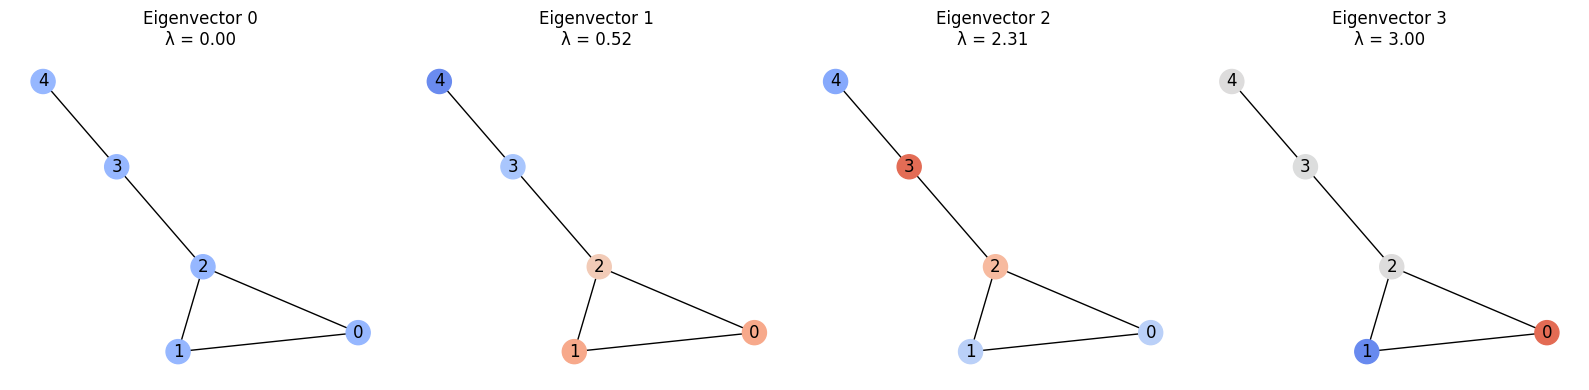

In [146]:
graph = build_example_graph()
plot_laplacian_eigenvectors(graph, num_vecs=4)

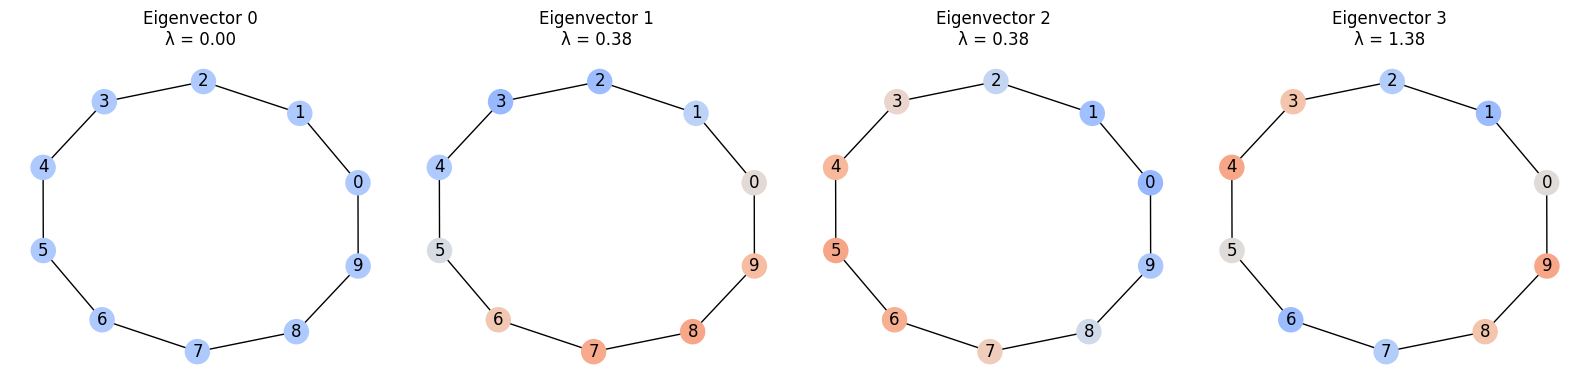

In [147]:
graph = build_circle_graph(10)
plot_laplacian_eigenvectors(graph, num_vecs=4)

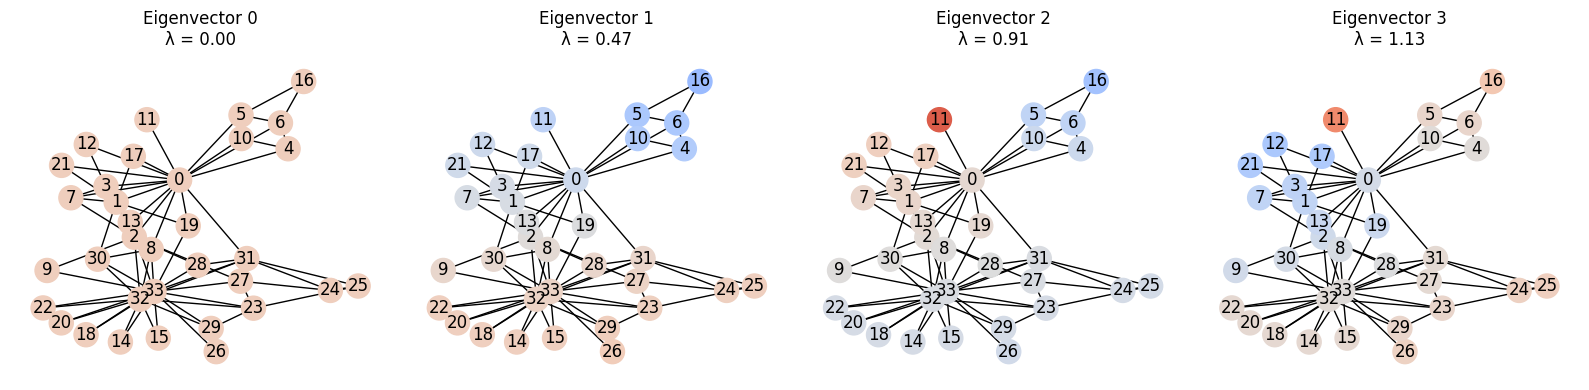

In [148]:
graph = build_karate_graph()
plot_laplacian_eigenvectors(graph, num_vecs=4)

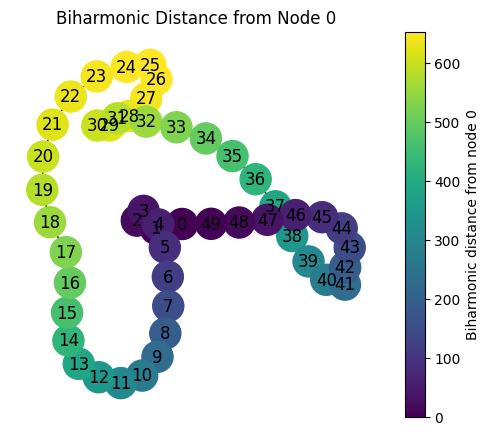

In [149]:
graph = build_circle_graph(50)
plot_biharmonic_distance(graph, source_node=0)

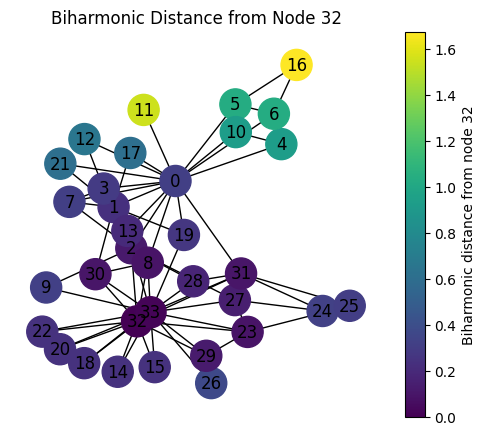

In [150]:
graph = build_karate_graph()
plot_biharmonic_distance(graph, source_node=32)

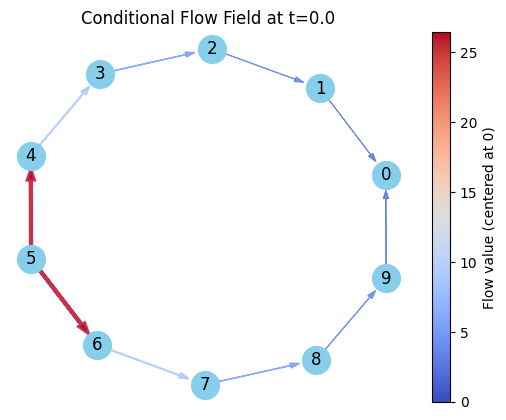

In [151]:
graph = build_circle_graph(10)
metric = BiharmonicDistance(graph)
t = 0.0
flow = conditional_flow_field(tau=0, rho=metric, t=t)
plot_edge_flow(graph, flow, title=f"Conditional Flow Field at {t=}")

In [152]:
graph = build_circle_graph(50)
tau = 25  # Target node

# Initial uniform distribution over nodes
p0 = uniform_distribution(graph)

# Biharmonic metric and conditional vector field
rho = BiharmonicDistance(graph)
nu_fn = lambda t: conditional_flow_field(tau, rho, t=t)

# Simulate and collect all intermediate states
trajectory = simulate_continuity_equation_trajectory(p0, nu_fn=nu_fn, num_steps=1000)

# Extract final state
p_final = trajectory[-1]

# Print or plot result
print("Final distribution coefficients:", p_final.coeffs)


coeffs_trajectory = jnp.vstack([c.coeffs for c in trajectory])
rho_tau = rho.conditional_distance(tau)
distances = jnp.vstack([jnp.inner(rho_tau.coeffs, c) for c in coeffs_trajectory])

Final distribution coefficients: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [158]:
coeffs_trajectory[-100]

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],      dtype=float32)

(0.0, 2.0)

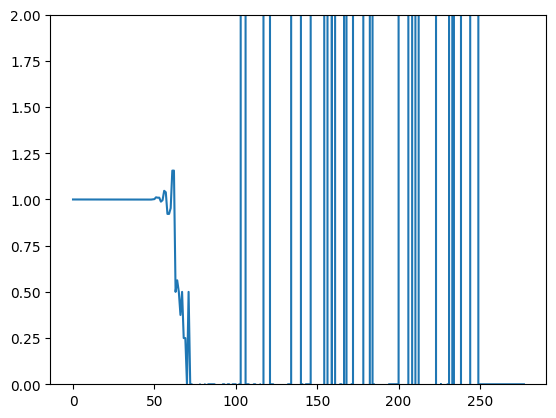

In [159]:
plt.plot(jnp.sum(coeffs_trajectory, axis=1))
plt.ylim(0, 2)

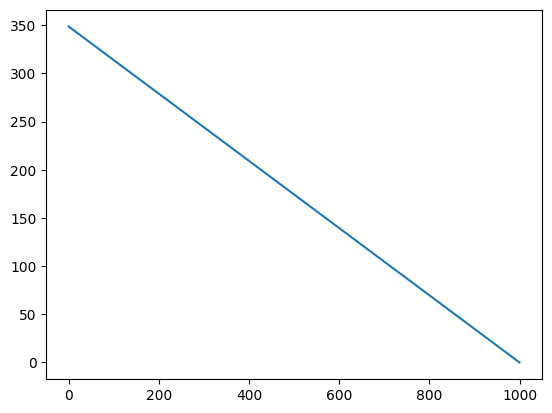

In [170]:
plt.plot(distances)

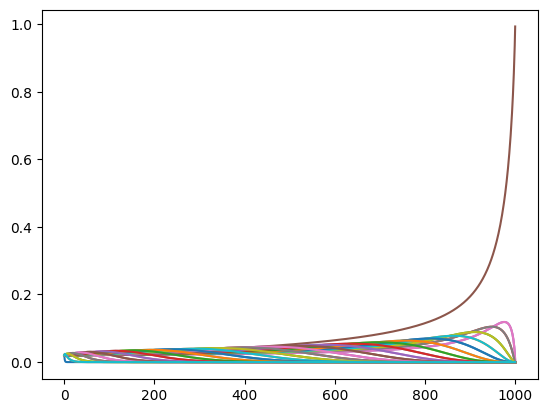

In [171]:
plt.plot(coeffs_trajectory)

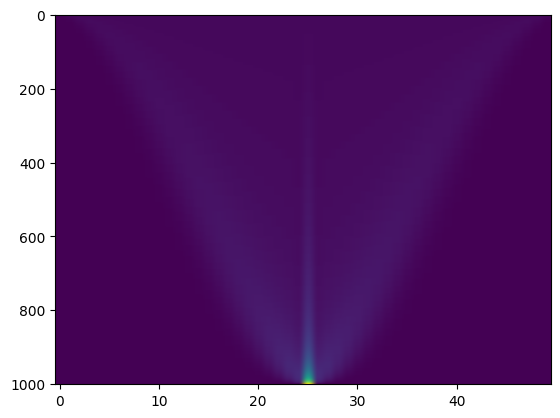

In [172]:
plt.imshow(coeffs_trajectory, aspect='auto', cmap='viridis')